In [3]:
import os
import tensorflow as tf
import numpy as np
import scipy.io
import pickle
import librosa.display
from scipy.io import wavfile
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from PIL import Image

In [4]:
#loading the weight and bias of the DAG object
mat = scipy.io.loadmat('v201.mat')
net = mat['net']
paras = net['params']
paras = paras.item()

In [5]:

#test image
image1 = Image.open("image1.png")
img1 = image1.resize((112,112),Image.BILINEAR)
image_arr_1 = np.array(img1)

image2 = Image.open("image2.png")
img2 = image1.resize((112,112),Image.BILINEAR)
image_arr_2 = np.array(img2) 

image3 = Image.open("image3.png")
img3 = image1.resize((112,112),Image.BILINEAR)
image_arr_3 = np.array(img3) 

image4 = Image.open("image4.png")
img4 = image4.resize((112,112),Image.BILINEAR)
image_arr_4 = np.array(img4) 

image5 = Image.open("image5.png")
img5 = image1.resize((112,112),Image.BILINEAR)
image_arr_5 = np.array(img5) 

face_image_1= np.concatenate((image_arr_1, image_arr_2,image_arr_3, image_arr_4, image_arr_5),axis=-1)
face_image_1.shape
face_image = face_image_1.reshape(1,112,112,15)

image_data = face_image


In [78]:
"""
#loading input audio of the model
(rate,sig) = wavfile.read("1.wav")
mfccs = mfcc(sig,samplerate=8500, winlen=0.04, winstep=0.35, numcep=13, nfilt=26, 
             nfft=512,lowfreq=0,highfreq=None, preemph=0.97,ceplifter=22, 
             appendEnergy=True, winfunc=np.hamming).T
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel')
print(mfccs.shape)
audio_data = mfccs[1:13,:]
print(audio_data.shape)
audio_data= audio_data.reshape(1,12,35,1)
"""

'\n#loading input audio of the model\n(rate,sig) = wavfile.read("1.wav")\nmfccs = mfcc(sig,samplerate=8500, winlen=0.04, winstep=0.35, numcep=13, nfilt=26, \n             nfft=512,lowfreq=0,highfreq=None, preemph=0.97,ceplifter=22, \n             appendEnergy=True, winfunc=np.hamming).T\nlibrosa.display.specshow(mfccs, x_axis=\'time\', y_axis=\'mel\')\nprint(mfccs.shape)\naudio_data = mfccs[1:13,:]\nprint(audio_data.shape)\naudio_data= audio_data.reshape(1,12,35,1)\n'

(13, 35)
(12, 35)


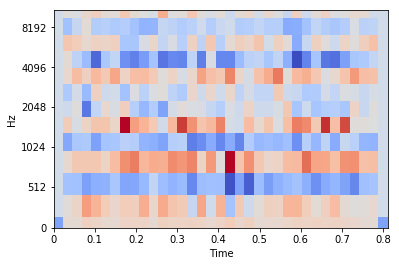

In [79]:

#loading input audio of the model
(rate,sig) = wavfile.read("testvideo.wav")
mfccs = mfcc(sig,samplerate=30000, winlen=0.04, winstep=0.35, numcep=13, nfilt=26, 
             nfft=2048,lowfreq=0,highfreq=None, preemph=0.97,ceplifter=22, 
             appendEnergy=True, winfunc=np.hamming).T
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel')
print(mfccs.shape)
audio_data = mfccs[1:13,:]
print(audio_data.shape)
audio_data= audio_data.reshape(1,12,35,1)


In [80]:
#exctracting the weight and bias of the model
import re
def model_creation(paras,filename):
    paras = paras
    filename = filename
    for i in paras['name']:
        name = i
        paras_num = []
        for j in range(len(name)):
            paras_num.append('%s'% name[j])
            
    paras_num_1 = []
    
    for i in paras_num:
        i = i
        p = re.findall(r'[\w]+',i)
        p_1 = str(p).replace("['","")
        p_2 = str(p_1).replace("']","")
        #print(p_2)
        paras_num_1.append(p_2)
        #print(type(paras_num_1))
        #print(len(paras_num_1))

        #print(name)
        #print(len(paras_num_1))
        model = {}
    for j in range(len(paras_num_1)):
        #print(paras_num_1[j])
        model[ '%s' % paras_num_1[j]] = paras['value'][0][j]
        #print(paras['value'][0][j].shape)
        #print(paras_num_1[j].shape)
    #for i in paras_num_1:
        #name = i
        #model = {}
        #for j in range(len(name)):
            #model['%s' % name[j]] = paras['value'][0][j]
    #model['conv1f_audio'] = paras[0][0]
    #model['conv1b_audio'] = paras[0][1]

    pickle.dump(model, open('%swb.npy'%filename, "wb" ))

In [46]:
model_creation(paras,'s2v')

In [47]:
s2vmodelPars = pickle.load(open("s2vwb.npy", "rb"))

In [69]:
class s2vmodelNN:
    """Builds net structure,
       load weights and bias from pre-train models.
    """
    def __init__(self, s2vmodelPars):
        self.s2vmodelPars = s2vmodelPars
        
        
    def get_weight_paras(self, wp):
        w_p = tf.constant(self.s2vmodelPars[wp], name = 'conv')
        return w_p
    
    def get_bias_paras(self, bp):
        b_p = tf.constant(self.s2vmodelPars[bp], name = 'bias')
        b_p = tf.reshape(b_p,[-1])
        return b_p
    
    def get_bn_mean_paras(self, mean_name):
        m_n = tf.constant(self.s2vmodelPars[mean_name][:,0])
        m_n = tf.reshape(m_n,[-1])
        return m_n
    
    def get_bn_variance_paras(self, variance_name):
        v_n = tf.constant(self.s2vmodelPars[variance_name][:,1])
        v_n = tf.reshape(v_n,[-1])
        return v_n
    
    def convolutional_layer(self, x, name, wp, bp):
        with tf.name_scope(name):
            conv_w = self.get_weight_paras(wp)
            conv_b = self.get_bias_paras(bp)
            print(conv_w)
            print(conv_b)
            h = tf.nn.conv2d(x, filter=conv_w, strides=[1,1,1,1], padding='SAME')
            h = tf.nn.bias_add(h, conv_b)
            return h
    def convolutional_layer_1(self, x, name, wp, bp):
        with tf.name_scope(name):
            conv_w = self.get_weight_paras(wp)
            conv_b = self.get_bias_paras(bp)
            print(conv_w)
            print(conv_b)
            h = tf.nn.conv2d(x, filter=conv_w, strides=[1,2,2,1], padding='VALID')
            h = tf.nn.bias_add(h, conv_b)
            return h
    
    def convolutional_layer_2(self, x, name, wp, bp):
        with tf.name_scope(name):
            conv_w = self.get_weight_paras(wp)
            conv_b = self.get_bias_paras(bp)
            print(conv_w)
            print(conv_b)
            h = tf.nn.conv2d(x, filter=conv_w, strides=[1,2,2,1], padding='VALID')
            h = tf.nn.bias_add(h, conv_b)
            return h    
    def convolutional_layer_3(self, x, name, wp, bp):
        with tf.name_scope(name):
            conv_w = self.get_weight_paras(wp)
            conv_b = self.get_bias_paras(bp)
            print(conv_w)
            print(conv_b)
            h = tf.nn.conv2d(x, filter=conv_w, strides=[1,2,2,1], padding='SAME')
            h = tf.nn.bias_add(h, conv_b)
            return h
    def convolutional_layer_4(self, x, name, wp, bp):
        with tf.name_scope(name):
            conv_w = self.get_weight_paras(wp)
            conv_b = self.get_bias_paras(bp)
            print(conv_w)
            print(conv_b)
            h = tf.nn.conv2d(x, filter=conv_w, strides=[1,1,1,1], padding='VALID')
            h = tf.nn.bias_add(h, conv_b)
            return h
    
    def batch_normalization_layer(self, x, name, mean_variance, beta, gamma, epsilon = 1e-3):
        with tf.name_scope(name):
            bn_mean = self.get_bn_mean_paras(mean_variance)
            bn_variance = self.get_bn_variance_paras(mean_variance)
            bn_beta = self.get_bias_paras(beta)
            bn_gamma = self.get_bias_paras(gamma)
            bn = tf.nn.batch_normalization(x, bn_mean, bn_variance, bn_beta, bn_gamma, epsilon)
            return bn
    
    def relu_layer(self, x, name):
        with tf.name_scope(name):
            h = tf.nn.relu(x)
            return h
        
    def sigmoid_layer(self, x, name):
        with tf.name_scope(name):
            h = tf.nn.sigmoid(x)
            return h
        
    def pooling_layer(self, x, name):
        with tf.name_scope(name):
            pool = tf.nn.max_pool(x,
                              ksize = [1,3,3,1],
                              strides = [1,2,2,1],
                              padding = 'VALID')
            return pool
        
    def pooling_layer_2(self, x, name):
        with tf.name_scope(name):
            pool = tf.nn.max_pool(x,
                              ksize = [1,3,3,1],
                              strides = [1,1,2,1],
                              padding = 'SAME')
            return pool
        
    def pooling_layer_3(self, x, name):
        with tf.name_scope(name):
            pool = tf.nn.max_pool(x,
                              ksize = [1,3,3,1],
                              strides = [1,2,2,1],
                              padding = 'SAME')
            return pool


    def up_samping_layer(self, x, size, name):
        with tf.name_scope(name):
            upsamp = tf.image.resize_bilinear(x,
                                            size,
                                            align_corners = False)
            return upsamp

        
        
    def build(self, input_1, input_2):
        
        audio_encoder_input = input_1
        identity_encoder_input =input_2

        """audio"""
        self.conv1_audio = self.convolutional_layer(audio_encoder_input, 'conv1_audio', 'conv1f_audio', 'conv1b_audio')
        self.bn1_audio = self.batch_normalization_layer(self.conv1_audio, 'bn1_audio', 'bn1x_audio', 'bn1b_audio', 'bn1m_audio')
        self.relu1_audio = self.relu_layer(self.bn1_audio, 'relu1_audio')
        
        print(self.conv1_audio)
        print(self.bn1_audio)
        print(self.relu1_audio)
        print('\n')
        
        self.conv2_audio = self.convolutional_layer(self.relu1_audio, 'conv2_audio', 'conv2f_audio', 'conv2b_audio')
        self.bn2_audio = self.batch_normalization_layer(self.conv2_audio, 'bn2_audio', 'bn2x_audio', 'bn2b_audio', 'bn2m_audio')
        self.relu2_audio = self.relu_layer(self.bn2_audio, 'relu2_audio')
        self.pool2_audio = self.pooling_layer_2(self.relu2_audio, 'pool2_audio')
        #ksize = [1,3,3,1],strides = [1,1,2,1],padding = 'SAME'
        print(self.conv2_audio)
        print(self.bn2_audio)
        print(self.relu2_audio)
        print(self.pool2_audio)
        print('\n')
        
        
        self.conv3_audio = self.convolutional_layer(self.pool2_audio, 'conv3_audio', 'conv3f_audio', 'conv3b_audio')
        self.bn3_audio = self.batch_normalization_layer(self.conv3_audio, 'bn3_audio', 'bn3x_audio', 'bn3b_audio', 'bn3m_audio')
        self.relu3_audio = self.relu_layer(self.bn3_audio, 'relu3_audio')
        print(self.conv3_audio)
        print(self.bn3_audio)
        print(self.relu3_audio)
        print('\n')
        
        
        self.conv4_audio = self.convolutional_layer(self.relu3_audio, 'conv4_audio', 'conv4f_audio', 'conv4b_audio')
        self.bn4_audio = self.batch_normalization_layer(self.conv4_audio, 'bn4_audio', 'bn4x_audio', 'bn4b_audio', 'bn4m_audio')
        self.relu4_audio = self.relu_layer(self.bn4_audio, 'relu4_audio')
        print(self.conv4_audio)
        print(self.bn4_audio)
        print(self.relu4_audio)
        print('\n')
        
        self.conv5_audio = self.convolutional_layer(self.relu4_audio, 'conv5_audio', 'conv5f_audio', 'conv5b_audio')
        self.bn5_audio = self.batch_normalization_layer(self.conv5_audio, 'bn5_audio', 'bn5x_audio', 'bn5b_audio', 'bn5m_audio')
        self.relu5_audio = self.relu_layer(self.bn5_audio, 'relu5_audio')
        self.pool5_audio = self.pooling_layer(self.relu5_audio, 'pool5_audio')
        #ksize = [1,3,3,1],strides = [1,2,2,1],padding = 'VALID'
        print(self.conv5_audio)
        print(self.bn5_audio)
        print(self.relu5_audio)
        print(self.pool5_audio)
        print('\n')
        
        self.fc6_audio = self.convolutional_layer_4(self.pool5_audio, 'fc6_audio', 'fc6f_audio', 'fc6b_audio')
        self.bn6_audio = self.batch_normalization_layer(self.fc6_audio, 'bn6_audio', 'bn6x_audio', 'bn6b_audio', 'bn6m_audio')
        self.relu6_audio = self.relu_layer(self.bn6_audio, 'relu6_audio')
        print(self.fc6_audio)
        print(self.bn6_audio)
        print(self.relu6_audio)
        print('\n')
        
        self.fc7_audio = self.convolutional_layer_4(self.relu6_audio, 'fc7_audio', 'fc7f_audio', 'fc7b_audio')
        print(self.fc7_audio)
        self.bn7_audio = self.batch_normalization_layer(self.fc7_audio, 'bn7_audio', 'bn7x_audio', 'bn7b_audio', 'bn7m_audio')
        self.relu7_audio = self.relu_layer(self.bn7_audio, 'relu7_audio')
        print(self.bn7_audio)
        print(self.relu7_audio)
        print('\n')
        
        
        """face"""
        self.conv1_face = self.convolutional_layer_2(identity_encoder_input, 'conv1_face', 'conv1f_face', 'conv1b_face')
        #strides=[1,2,2,1], padding='VALID'
        self.bn1_face = self.batch_normalization_layer(self.conv1_face, 'bn1_face', 'bn1x_face', 'bn1b_face', 'bn1m_face')
        self.relu1_face = self.relu_layer(self.bn1_face, 'relu1_face')
        self.pool1_face = self.pooling_layer_3(self.relu1_face, 'pool1_face')
        #strides = [1,2,2,1],padding = 'SAME'
        print(self.conv1_face)
        print(self.bn1_face)
        print(self.relu1_face)
        print(self.pool1_face)
        print('\n')
        
        self.conv2_face = self.convolutional_layer_2(self.pool1_face, 'conv2_face', 'conv2f_face', 'conv2b_face')
        #strides=[1,2,2,1], padding='VALID'
        self.bn2_face = self.batch_normalization_layer(self.conv2_face, 'bn2_face', 'bn2x_face', 'bn2b_face', 'bn2m_face')
        self.relu2_face = self.relu_layer(self.bn2_face, 'relu2_face')
        self.pool2_face = self.pooling_layer_3(self.relu2_face, 'pool2_face')
        #strides = [1,2,2,1],padding = 'SAME'
        print(self.conv2_face)
        print(self.bn2_face)
        print(self.relu2_face)
        print(self.pool2_face)
        print('\n')
        
        self.conv3_face = self.convolutional_layer(self.pool2_face, 'conv3_face', 'conv3f_face', 'conv3b_face')
        #strides=[1,1,1,1], padding='SAME'
        self.bn3_face = self.batch_normalization_layer(self.conv3_face, 'bn3_face', 'bn3x_face', 'bn3b_face', 'bn3m_face')
        self.relu3_face = self.relu_layer(self.bn3_face, 'relu3_face')
        print(self.conv3_face)
        print(self.bn3_face)
        print(self.relu3_face)
        print('\n')
        
        self.conv4_face = self.convolutional_layer(self.relu3_face, 'conv4_face', 'conv4f_face', 'conv4b_face')
        self.bn4_face = self.batch_normalization_layer(self.conv4_face, 'bn4_face', 'bn4x_face', 'bn4b_face', 'bn4m_face')
        self.relu4_face = self.relu_layer(self.bn4_face, 'relu4_face')
        print(self.conv4_face)
        print(self.bn4_face )
        print(self.relu4_face)
        print('\n')
        
        self.conv5_face = self.convolutional_layer(self.relu4_face, 'conv5_face', 'conv5f_face', 'conv5b_face')
        self.bn5_face = self.batch_normalization_layer(self.conv5_face, 'bn5_face', 'bn5x_face', 'bn5b_face', 'bn5m_face')
        self.relu5_face = self.relu_layer(self.bn5_face, 'relu5_face')
        print(self.conv5_face)
        print(self.bn5_face)
        print(self.relu5_face)
        print('\n')
        
        self.conv6_face = self.convolutional_layer_4(self.relu5_face, 'conv6_face', 'conv6f_face', 'conv6b_face')
        #strides=[1,2,2,1], padding='VALID'
        self.bn6_face = self.batch_normalization_layer(self.conv6_face, 'bn6_face', 'bn6x_face', 'bn6b_face', 'bn6m_face')
        self.relu6_face = self.relu_layer(self.bn6_face, 'relu6_face')
        print(self.conv6_face)
        print(self.bn6_face)
        print(self.relu6_face)
        print('\n')
        
        self.conv7_face = self.convolutional_layer_4(self.relu6_face, 'conv7_face', 'conv7f_face', 'conv7b_face')
        #strides=[1,2,2,1], padding='VALID'
        self.bn7_face = self.batch_normalization_layer(self.conv7_face, 'bn7_face', 'bn7x_face', 'bn7b_face', 'bn7m_face')
        print(self.conv7_face)
        self.relu7_face = self.relu_layer(self.bn7_face, 'relu7_face')
        print(self.bn7_face)
        print(self.relu7_face)
        print('\n')
        
        self.concat8 = tf.concat([self.relu7_audio, self.relu7_face], axis = -1)
        print(self.concat8)
        print('\n')
        
        
        
        self.conv8 = self.convolutional_layer(self.concat8, 'conv8', 'c8f', 'c8b')
        self.relu8 = self.relu_layer(self.conv8, 'relu8')
        print(self.conv8)
        print(self.relu8)
        print('\n')
        
        
        
        
        self.upsamp1_1 = self.up_samping_layer(self.relu8, [20,20],'upsamp1_1')
        self.conv1_1 = self.convolutional_layer_4(self.upsamp1_1, 'conv1_1', 'uc1_1f', 'uc1_1b')
        #strides=[1,2,2,1], padding='SAME'
        self.relu1_1 = self.relu_layer(self.conv1_1, 'relu1_1')
        print(self.upsamp1_1)
        print(self.conv1_1)
        print(self.relu1_1)
        print('\n')
        
        
        self.conv1_2 = self.convolutional_layer_4(self.relu1_1, 'conv1_2', 'uc1_2f', 'uc1_2b')
        #strides=[1,2,2,1], padding='SAME'
        self.relu1_2 = self.relu_layer(self.conv1_2, 'relu1_2')
        print(self.conv1_2)
        print(self.relu1_2)
        print('\n')
        
        self.conv1_3 = self.convolutional_layer_4(self.relu1_2, 'conv1_3', 'uc1_3f', 'uc1_3b')
        #strides=[1,2,2,1], padding='SAME'
        self.relu1_3 = self.relu_layer(self.conv1_3, 'relu1_3')
        print(self.conv1_3)
        print(self.relu1_3)
        print('\n')
        
        
        self.upsamp2 = self.up_samping_layer(self.relu1_3, [12,12], 'upsamp2')
        
        self.conv2 = self.convolutional_layer(self.upsamp2, 'conv2', 'uc2f', 'uc2b')
        #strides=[1,2,2,1], padding='SAME'
        self.relu2 = self.relu_layer(self.conv2, 'relu2')
        #print(self.upsamp2)
        print(self.conv2)
        print(self.relu2)
        print('\n')
        
        self.concatSkip2 = tf.concat([self.relu2_face, self.relu2], axis = -1)
        print(self.concatSkip2)
        print('\n')
        
        self.upsamp3 = self.up_samping_layer(self.concatSkip2, [33,33], 'upsamp3')
        
        self.conv3_1 = self.convolutional_layer_4(self.upsamp3, 'conv3_1', 'uc3_1f', 'uc3_1b')
        #strides=[1,2,2,1], padding='SAME'
        self.relu3_1 = self.relu_layer(self.conv3_1, 'relu3_1')
        
        print(self.conv3_1)
        print(self.relu3_1)
        print('\n')
        
        
        self.conv3_2 = self.convolutional_layer_4(self.relu3_1, 'conv3_2', 'uc3_2f', 'uc3_2b')
        #strides=[1,2,2,1], padding='SAME'
        self.relu3_2 = self.relu_layer(self.conv3_2, 'relu3_2')
        
        print(self.conv3_2)
        print(self.relu3_2)
        print('\n')
        
        self.concatSkip3 = tf.concat([self.pool1_face, self.relu3_2], axis = -1)
        print(self.concatSkip3)
        print('\n')
        
        
        self.upsamp4 = self.up_samping_layer(self.concatSkip3, [55,55], 'upsamp4')
        
        self.conv4 = self.convolutional_layer_4(self.upsamp4, 'conv4', 'uc4f', 'uc4b')
        #strides=[1,2,2,1], padding='SAME'
        self.relu4 = self.relu_layer(self.conv4, 'relu4')
        print(self.upsamp4)
        print(self.conv4)
        print(self.relu4)
        print('\n')
        
        self.concatSkip4 = tf.concat([self.relu1_face, self.relu4], axis = -1)
        print(self.concatSkip4)
        print('\n')
        
        
        self.upsamp5 = self.up_samping_layer(self.concatSkip4, [113,113], 'upsamp5')
        self.conv5_1 = self.convolutional_layer_4(self.upsamp5, 'conv5_1', 'uc5_1f', 'uc5_1b')
        #strides=[1,1,1,1], padding='SAME'
        self.relu5_1 = self.relu_layer(self.conv5_1, 'relu5_1')
        print(self.conv5_1)
        print(self.relu5_1)
        print('\n')
        

        self.conv5_2 = self.convolutional_layer_4(self.relu5_1, 'conv5_2', 'uc5_2f', 'uc5_2b')
        self.relu5_2 = self.relu_layer(self.conv5_2, 'relu5_2')
        print(self.conv5_2)
        print(self.relu5_2)
        print('\n')
        

        self.conv5_3 = self.convolutional_layer(self.relu5_2, 'conv5_3', 'uc5_3f', 'uc5_3b')
        self.sigmoid5_3 = self.sigmoid_layer(self.conv5_3, 'sigmoid5_3')
        print(self.conv5_3)
        print(self.sigmoid5_3)
        print('\n')
        
        
        output = self.sigmoid5_3

        
        return output

In [70]:
#run the model and get the prediction output
tf.reset_default_graph()

input_1 = tf.placeholder(tf.float32, shape = [1,12, 35, 1])
input_2 = tf.placeholder(tf.float32, shape = [1,112, 112, 15])
        
initial_s2vmodelNN = s2vmodelNN(s2vmodelPars)

output = initial_s2vmodelNN.build(input_1, input_2)

LOG_DIR ='.'
run_tsb ='run_tensorboard'
run_dir = os.path.join(LOG_DIR,run_tsb)
if not os.path.exists(run_dir):
    os.mkdir(run_dir)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(output,feed_dict = {input_1:audio_data,input_2:image_data})
    writer = tf.summary.FileWriter(run_dir,tf.get_default_graph())
    writer.close()

Tensor("conv1_audio/conv:0", shape=(3, 3, 1, 64), dtype=float32)
Tensor("conv1_audio/Reshape:0", shape=(64,), dtype=float32)
Tensor("conv1_audio/BiasAdd:0", shape=(1, 12, 35, 64), dtype=float32)
Tensor("bn1_audio/batchnorm/add_1:0", shape=(1, 12, 35, 64), dtype=float32)
Tensor("relu1_audio/Relu:0", shape=(1, 12, 35, 64), dtype=float32)


Tensor("conv2_audio/conv:0", shape=(3, 3, 64, 128), dtype=float32)
Tensor("conv2_audio/Reshape:0", shape=(128,), dtype=float32)
Tensor("conv2_audio/BiasAdd:0", shape=(1, 12, 35, 128), dtype=float32)
Tensor("bn2_audio/batchnorm/add_1:0", shape=(1, 12, 35, 128), dtype=float32)
Tensor("relu2_audio/Relu:0", shape=(1, 12, 35, 128), dtype=float32)
Tensor("pool2_audio/MaxPool:0", shape=(1, 12, 18, 128), dtype=float32)


Tensor("conv3_audio/conv:0", shape=(3, 3, 128, 256), dtype=float32)
Tensor("conv3_audio/Reshape:0", shape=(256,), dtype=float32)
Tensor("conv3_audio/BiasAdd:0", shape=(1, 12, 18, 256), dtype=float32)
Tensor("bn3_audio/batchnorm/add_1:0", shape

In [71]:
np.shape(result[0])
result0=result[0]
#result[:,:,0].shape

<function matplotlib.pyplot.show(*args, **kw)>

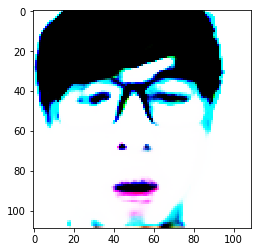

In [72]:
plt.imshow(result0)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

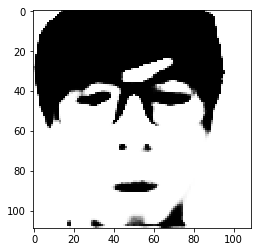

In [73]:
plt.imshow(result0[:,:,0],cmap='gray')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

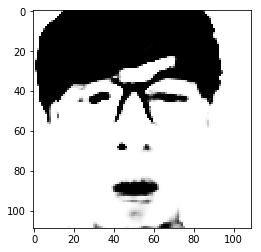

In [74]:
plt.imshow(result0[:,:,1],cmap='gray')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

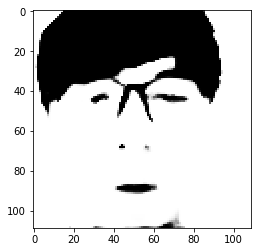

In [75]:
plt.imshow(result0[:,:,2],cmap='gray')
plt.show